Start by importing the required libraries.

In [290]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

Read the image.

In [291]:
img = cv2.imread('image.png')

Since this image is in BGR color space, we need to re-arrange it into an RGB color space.

In [292]:
# BGR to RGB
b,g,r = cv2.split(img)
img = cv2.merge([r,g,b])

In order to accurately detect a rectangle, we need to do the following,

- Convert from RGB color space to a single grayscale channel.
- Smooth the image to remove any noise.
- Threshold the pixel values so the image is black and white with the most prominent features.
- Edge detection, this will help us detect the contours in the next step.
- Detect the contours of the image to use in shape analysis.
- Since contours are continuous curves, we need to approximate their approximate shape.
- Find the rectangles where:
  - the polygonalized contour has 4 points
  - the polygonalized contour has sufficient area
  - the polygonalized contour has adjacent edges that were ~90 degrees
  - had distance between "opposite" vertices was of sufficient size, etc.

https://answers.opencv.org/question/223919/unable-to-find-and-draw-biggest-contour/

In [293]:
# RGB to GRAYSCALE
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [294]:
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)

    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return rect

def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)

    (tl, tr, br, bl) = rect
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dstPts = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dstPts)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    # return the warped image
    return warped

def distance(pt1, pt2):
    d = math.sqrt(pow(pt2[0] - pt1[0], 2) + pow(pt2[1] - pt1[1], 2))
    return d

def dotproduct(pt1, pt2):
    dp = (pt1[0] * pt2[0]) + (pt1[1] * pt2[1])
    return dp

def angle(p1, p2, p3):
    a = [p1[0] - p2[0], p1[1] - p2[1]]
    b = [p1[0] - p3[0], p1[1] - p3[1]]

    ab = dotproduct(a, b)
    d1 = math.sqrt(pow(a[0], 2) + pow(a[1], 2))
    d2 = math.sqrt(pow(b[0], 2) + pow(b[1], 2))
    # arc of cosine in radians
    ac = math.acos(ab / (d1 * d2))
    # convert to degrees
    deg = ac *  (180 / math.pi)
    return deg

In [295]:
blur = cv2.GaussianBlur(gray, (5,5), 0)

ret,thresh = cv2.threshold(blur, 127, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

thresh2 = cv2.adaptiveThreshold(thresh, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

edges = cv2.Canny(thresh2, 100, 200)

# RETR_TREE / RETR_EXTERNAL
contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# shape returns rows, columns, and channels (if color image)
(h, w) = edges.shape
minArea = h * w * 0.5

boxes = []
maxlength = max(map(len, contours))

# Search contours for ones of interest
for cnt in contours : 
    area = cv2.contourArea(cnt)
    
    # Filter contours based on their area.
    # In our case, at a minimum the contours of interest should be
    # at least half the area of the total image.
    # This will eliminate contours that are there from a noisy image.
    if area > minArea:
        # approxPolyDP -- Approximates a polygonal curve(s) with the specified precision.
        epsilon = 0.0009 * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)

        # Check if the polygon equals 4 sides
        if(len(approx) == 4):
            box = cv2.boxPoints(rect)
            box = np.float32(box)
            boxes.append(box)

            a1 = angle(box[0], box[3], box[1])
            a2 = angle(box[1], box[0], box[2])
            a3 = angle(box[2], box[1], box[3])
            a4 = angle(box[3], box[2], box[0])
            print((a1, a2, a3, a4))
            # cv2.drawContours(edges, [approx], 0, (255, 255, 255), 25) 


pts1 = boxes[0]

dst = four_point_transform(img, pts1)

(89.9999968266778, 90.00000290887826, 89.99999048003477, 90.0000100488537)
(89.9999968266778, 90.00000290887826, 89.99999048003477, 90.0000100488537)
(89.9999968266778, 90.00000290887826, 89.99999048003477, 90.0000100488537)
(89.9999968266778, 90.00000290887826, 89.99999048003477, 90.0000100488537)


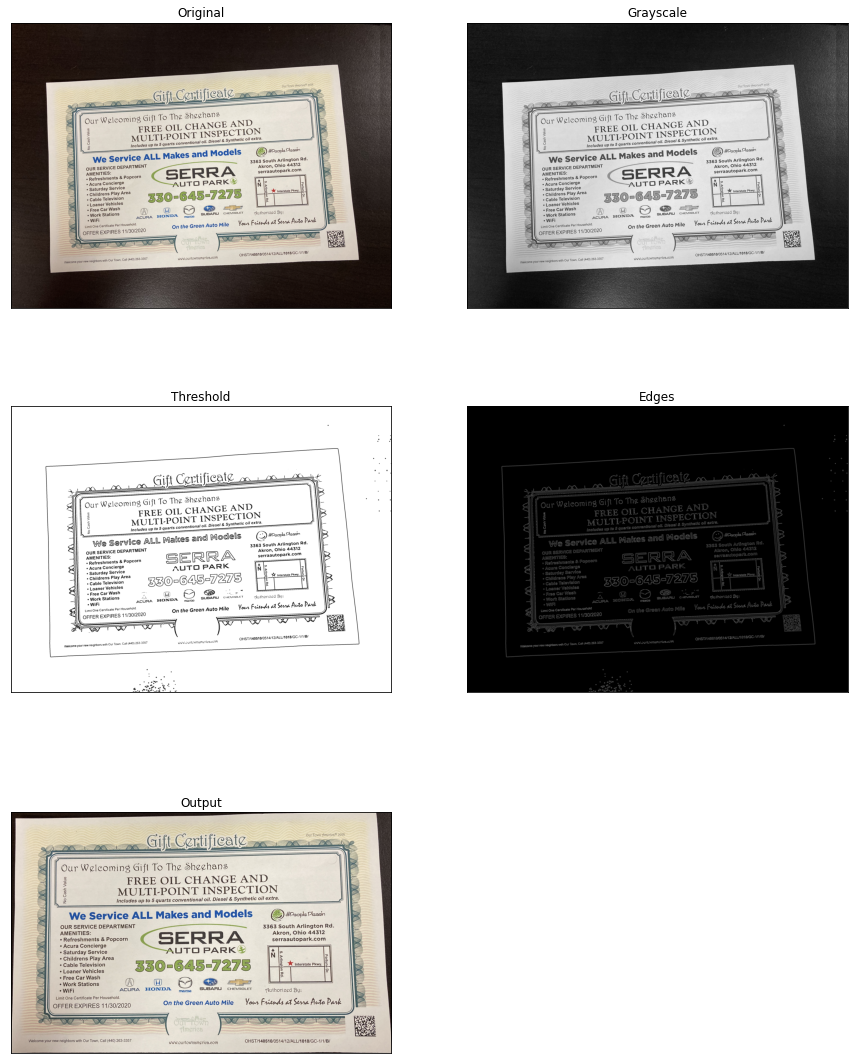

In [296]:
plt.figure(figsize=(15, 20))
plt.axes([0,0,1,1], frameon=False)
plt.autoscale(tight=True)
# plt.xticks([])
# plt.yticks([])
plt.axis('off')
plt.box(on=None)

images = [img, gray, thresh2, edges, dst]
titles = ["Original", "Grayscale", "Threshold", "Edges", "Output"]
positions = [1, 2, 3, 4, 5]

for i, (img, title, pos) in enumerate(zip(images, titles, positions)):
    plt.subplot(3, 2, pos)              # rows, columns, position
    plt.imshow(img, cmap='gray')        # grayscale colormap for single channel images
    plt.title(title)
    plt.xticks([])
    plt.yticks([])

plt.show()